Import Statements

In [52]:
## Imports
import os
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn.model_selection import train_test_split
import torch

def label_to_int(label):
    if "palm" in label:
        return 0
    if "spher" in label:
        return 1
    if "hook" in label:
        return 2
    if "cyl" in label:
        return 3
    if "lat" in label:
        return 4
    if "tip" in label:
        return 5
        

# Read Data

Outputs:

    clients - list of client ids

    train_data/test_data - nested dictionary

                    first key: client id
                    
                            second keys: 'x' and 'y'


In [124]:
def read_data():
    # holds intermediate data
    X = np.empty((0,2,3000))
    y = np.empty(0) 
    #30 Samples, 2 Variables, 3000 Time Steps
    X_intermediate = np.zeros((30,2,3000)) #To be 3D array of sample, variables, time step
    y_intermediate = np.empty(30) #To be Labels
    channel1 = np.empty((30,3000))
    channel2 = np.empty((30,3000))
    label = ""
    directory1 = "Database 1"
    clients = []
    data_dict = {}
    nested_dictionary = {}

    #Load All Data In
    for root, subdirectories, files in os.walk(directory1):
        for file in files:
            path = os.path.join(root, file)
            if ".mat" in path:
                data = loadmat(path)
                clientid = re.search("([^.]+)", file).group(0)
                clients = np.append(clients, clientid)
                for x in data.keys():
                    if "1" in x:
                        label = re.search("([^_]+)", x).group(0)
                        label = label_to_int(label)
                        channel1 = data.get(x)
                        channel1 = (channel1-np.mean(channel1))/np.std(channel1)
                    if "2" in x:
                        channel2 = data.get(x)
                        channel2 = (channel2-np.mean(channel2))/np.std(channel2)
                        for i in range(30):
                            X_intermediate[i, :, :] = np.array([channel1[i,:], channel2[i,:]])
                            y_intermediate[i] = label
                        X = np.append(X, X_intermediate, axis=0)
                        y = np.append(y, y_intermediate, axis=0)
                nested_dictionary = {clientid: {'x' : X, 'y' :  y}}
                data_dict.update(nested_dictionary)
                X = np.empty((0,2,3000))
                y = np.empty(0)

    #Split into test and train
    train_data = {}
    test_data = {}
    for i in data_dict.keys():
        client_data = data_dict[i]
        X_train, X_test, y_train, y_test = train_test_split(client_data["x"], client_data["y"], test_size=0.3, stratify=client_data["y"])
        nested_dictionary = {i: {'x' : X_train, 'y' :  y_train}}
        train_data.update(nested_dictionary)
        nested_dictionary = {i: {'x' : X_test, 'y' :  y_test}}
        test_data.update(nested_dictionary)

    return clients, train_data, test_data


## Batch Data - Splits Data of a Single Client into Batches

In [82]:
def batch_data(data, batch_size):
    '''
    data is a dict := {'x': [numpy array], 'y': [numpy array]} (on one client)
    returns x, y, which are both numpy array of length: batch_size
    '''
    data_x = data['x']
    data_y = data['y']

    # randomly shuffle data
    np.random.seed(100)
    rng_state = np.random.get_state()
    np.random.shuffle(data_x)
    np.random.set_state(rng_state)
    np.random.shuffle(data_y)

    # loop through mini-batches
    batch_data = list()
    for i in range(0, len(data_x), batch_size):
        batched_x = data_x[i:i + batch_size]
        batched_y = data_y[i:i + batch_size]
        batched_x = torch.from_numpy(np.asarray(batched_x)).float()
        batched_y = torch.from_numpy(np.asarray(batched_y)).long()
        batch_data.append((batched_x, batched_y))
    return batch_data

# load_partiition_data
    Outputs:

    client_num - int of number of clients
    train_data_num - total number of training data
    test_data_num - total number of testing data
    train_data_global - list of all train batches
    test_data_global - list of all test batches
    train_data_local_num_dict - dictionary: keys client number that holds the length of client data
    train_data_local_dict - dictionary of client data: key client id
    same goes for test versions
    class_num - # of labels

In [122]:
def load_partition_data_semg(batch_size):
    clients, train_data, test_data = read_data()

    train_data_num = 0
    test_data_num = 0
    train_data_local_dict = dict()
    test_data_local_dict = dict()
    train_data_local_num_dict = dict()
    train_data_global = list()
    test_data_global = list()
    client_idx = 0

    #logging.info("loading data...")

    for i in clients:
        user_train_data_num = len(train_data[i]['x'])
        user_test_data_num = len(test_data[i]['x'])
        train_data_num += user_train_data_num
        test_data_num += user_test_data_num
        train_data_local_num_dict[client_idx] = user_train_data_num

        # transform to batches
        train_batch = batch_data(train_data[i], 10)
        test_batch = batch_data(test_data[i], 10)

        # index using client index
        train_data_local_dict[client_idx] = train_batch
        test_data_local_dict[client_idx] = test_batch
        train_data_global += train_batch
        test_data_global += test_batch
        client_idx += 1

    #logging.info("finished the loading data")

    client_num = client_idx
    class_num = 6
    return client_num, train_data_num, test_data_num, train_data_global, test_data_global, train_data_local_num_dict, train_data_local_dict, test_data_local_dict, class_num




In [137]:
client_num, train_data_num, test_data_num, train_data_global, test_data_global, train_data_local_num_dict, train_data_local_dict, test_data_local_dict, class_num = load_partition_data_semg(10)

In [127]:
import torch
from tsai.all import *

In [151]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [181]:

class CustomEMG(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        sample =[data, label]
        return sample

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim

In [329]:
#define model
model = InceptionTime(2,3000)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device);

#get Data
clients, train_data, test_data = read_data()

#Define Data list
train_data_list = []
train_labels_list = []
test_data_list = []
test_labels_list = []

#Load Data into Correct Format
for i in clients:
    for j in range(len(train_data[i]["x"])):
        x = train_data[i]["x"][j]
        y = train_data[i]["y"][j]
        train_data_list.append(x)
        train_labels_list.append(y)
for i in clients:
    for j in range(len(test_data[i]["x"])):
        x = test_data[i]["x"][j]
        y = test_data[i]["y"][j]
        test_data_list.append(x)
        test_labels_list.append(y)

#Convert to Dataset
train = CustomEMG(train_data_list, train_labels_list)
test = CustomEMG(test_data_list, test_labels_list )

#Create Dataloaders
train_dataloader = DataLoader(train, batch_size = 10, shuffle=True)
test_dataloader = DataLoader(test, batch_size = 10, shuffle=False)

In [330]:
i = 0
test_accuracy_run = []
train_accuracy_run = []
loss_run = []

for epoch in range(30):

    running_loss = 0.0
    for data in train_dataloader:
        inputs, targets = data[0].to(device), data[1].to(device)
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs.float())
        # calculate loss
        loss = criterion(yhat, targets.long())
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

        #get Test accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_dataloader:
                emg_test, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs = model(emg_test.float())
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct // total

        # Get Train Accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in train_dataloader:
                emg_train, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs = model(emg_train.float())
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct // total

        #append to running totals
        test_accuracy_run.append(test_accuracy)
        train_accuracy_run.append(train_accuracy)
        loss_run.append(loss.item())

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
        i = i + 1
print('Finish Training')

[1,    10] loss: 7.059
[1,    20] loss: 4.632
[1,    30] loss: 2.704
[1,    40] loss: 1.992
[1,    50] loss: 1.748
[1,    60] loss: 1.620
[2,    70] loss: 1.111
[2,    80] loss: 1.570
[2,    90] loss: 1.325
[2,   100] loss: 1.308
[2,   110] loss: 1.407
[2,   120] loss: 1.225
[3,   130] loss: 0.463
[3,   140] loss: 1.167
[3,   150] loss: 1.144
[3,   160] loss: 1.099
[3,   170] loss: 1.024
[3,   180] loss: 1.098
[4,   190] loss: 0.128
[4,   200] loss: 0.766
[4,   210] loss: 0.953
[4,   220] loss: 0.989
[4,   230] loss: 0.980
[4,   240] loss: 1.066
[4,   250] loss: 1.046
[5,   260] loss: 0.828
[5,   270] loss: 0.765
[5,   280] loss: 1.208
[5,   290] loss: 0.676
[5,   300] loss: 1.115
[5,   310] loss: 1.141
[6,   320] loss: 0.578
[6,   330] loss: 0.818
[6,   340] loss: 0.817
[6,   350] loss: 0.875
[6,   360] loss: 0.862
[6,   370] loss: 0.823
[7,   380] loss: 0.139
[7,   390] loss: 0.772
[7,   400] loss: 0.806
[7,   410] loss: 0.754
[7,   420] loss: 0.863
[7,   430] loss: 0.780
[7,   440] 

Text(0.5, 1.0, 'Test Accuracy')

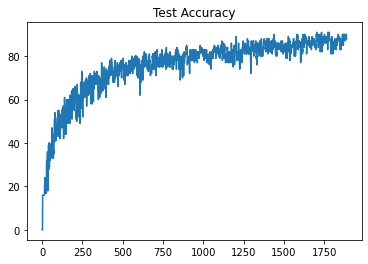

In [331]:
plt.plot(test_accuracy_run)
plt.title("Test Accuracy")

Text(0.5, 1.0, 'Train Accuracy')

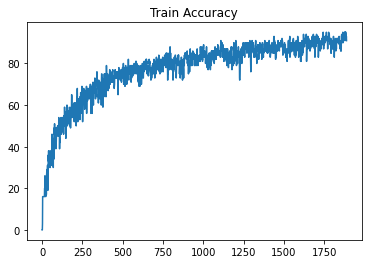

In [332]:
plt.plot(train_accuracy_run)
plt.title("Train Accuracy")

Text(0.5, 1.0, 'Train Loss')

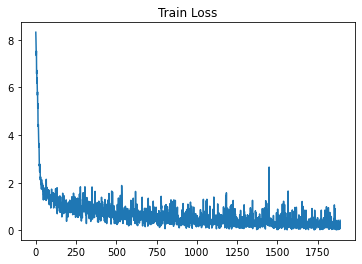

In [333]:
plt.plot(loss_run)
plt.title("Train Loss")

In [334]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        emg, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(emg.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test data: {100 * correct // total} %')


Accuracy of the network on the test data: 88 %


# Adding Loss for Test Data and Converting Graphs to be Based on Epoch

In [375]:
#define model
model = InceptionTime(2,3000)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device);

#get Data
clients, train_data, test_data = read_data()

#Define Data list
train_data_list = []
train_labels_list = []
test_data_list = []
test_labels_list = []

#Load Data into Correct Format
for i in clients:
    for j in range(len(train_data[i]["x"])):
        x = train_data[i]["x"][j]
        y = train_data[i]["y"][j]
        train_data_list.append(x)
        train_labels_list.append(y)
for i in clients:
    for j in range(len(test_data[i]["x"])):
        x = test_data[i]["x"][j]
        y = test_data[i]["y"][j]
        test_data_list.append(x)
        test_labels_list.append(y)

#Convert to Dataset
train = CustomEMG(train_data_list, train_labels_list)
test = CustomEMG(test_data_list, test_labels_list )

#Create Dataloaders
train_dataloader = DataLoader(train, batch_size = 10, shuffle=True)
test_dataloader = DataLoader(test, batch_size = 10, shuffle=False)

In [376]:
train_accu = []
train_losses = []
def train(epoch, round):
  print('\nEpoch : %d'%epoch)
  print('Communication Round : %d'%round)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in train_dataloader:
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    optimizer.zero_grad()
    outputs=model(inputs.float())
    loss=criterion(outputs,labels.long())
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(train_dataloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [377]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in test_dataloader:
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images.float())

      loss= criterion(outputs,labels.long())
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(test_dataloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [378]:
epochs=30
communication_rounds = 200
for round in range(1,communication_rounds+1):
  for epoch in range(1,epochs+1): 
    train(epoch, round)
    test(epoch)


Epoch : 1
Communication Round : 1
Train Loss: 3.207 | Accuracy: 25.873
Test Loss: 2.215 | Accuracy: 24.444

Epoch : 2
Communication Round : 1
Train Loss: 1.412 | Accuracy: 41.905
Test Loss: 2.700 | Accuracy: 22.593

Epoch : 3
Communication Round : 1
Train Loss: 1.131 | Accuracy: 56.190
Test Loss: 1.815 | Accuracy: 39.259

Epoch : 4
Communication Round : 1
Train Loss: 0.955 | Accuracy: 64.444
Test Loss: 0.875 | Accuracy: 68.519

Epoch : 5
Communication Round : 1
Train Loss: 0.892 | Accuracy: 64.921
Test Loss: 5.729 | Accuracy: 17.407

Epoch : 6
Communication Round : 1
Train Loss: 0.776 | Accuracy: 70.476
Test Loss: 1.202 | Accuracy: 58.148

Epoch : 7
Communication Round : 1
Train Loss: 0.676 | Accuracy: 73.016
Test Loss: 2.254 | Accuracy: 50.000

Epoch : 8
Communication Round : 1
Train Loss: 0.706 | Accuracy: 73.333
Test Loss: 0.894 | Accuracy: 65.926

Epoch : 9
Communication Round : 1
Train Loss: 0.619 | Accuracy: 76.508
Test Loss: 5.312 | Accuracy: 30.741

Epoch : 10
Communication Ro

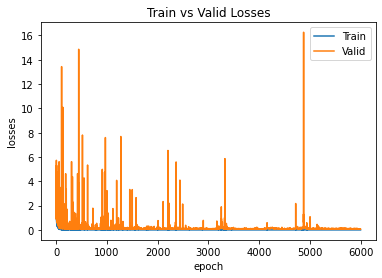

In [379]:
plt.plot(train_losses,'-')
plt.plot(eval_losses,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [389]:
int((len(train_accu)/30))

200

In [392]:
train_acc_round = []
test_acc_round = []
train_loss_round = []
test_loss_round = []
for i in range(int(len(train_accu)/30)):
    sum_acc_train = 0
    sum_acc_test = 0
    sum_loss_test = 0
    sum_loss_train = 0
    for j in range(30):
        sum_acc_train += train_accu[i*30+j]
        sum_acc_test += eval_accu[i*30+j]
        sum_loss_test += eval_losses[i*30+j]
        sum_loss_train += train_losses[i*30+j]
    sum_acc_train = sum_acc_train/30
    sum_acc_test = sum_acc_test/30
    sum_loss_test = sum_loss_test/30
    sum_loss_train = sum_loss_train/30
    train_acc_round.append(sum_acc_train)
    test_acc_round.append(sum_acc_test)
    test_loss_round.append(sum_loss_test)
    train_loss_round.append(sum_loss_train)


In [399]:
test_acc_round[-1]

96.41975308641969

Text(0.5, 1.0, 'Standard Learning Accuracy')

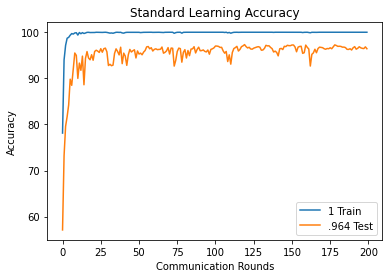

In [407]:
plt.plot(train_acc_round,'-')
plt.plot(test_acc_round,'-')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.legend(['1 Train','.964 Test'])
plt.title('Standard Learning Accuracy')

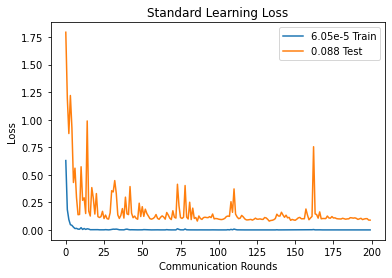

In [408]:
plt.plot(train_loss_round,'-')
plt.plot(test_loss_round,'-')
plt.xlabel('Communication Rounds')
plt.ylabel('Loss')
plt.legend(['6.05e-5 Train','0.088 Test'])
plt.title('Standard Learning Loss')

plt.show()

# 1 Communication Round

In [409]:
#define model
model = InceptionTime(2,3000)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device);

#get Data
clients, train_data, test_data = read_data()

#Define Data list
train_data_list = []
train_labels_list = []
test_data_list = []
test_labels_list = []

#Load Data into Correct Format
for i in clients:
    for j in range(len(train_data[i]["x"])):
        x = train_data[i]["x"][j]
        y = train_data[i]["y"][j]
        train_data_list.append(x)
        train_labels_list.append(y)
for i in clients:
    for j in range(len(test_data[i]["x"])):
        x = test_data[i]["x"][j]
        y = test_data[i]["y"][j]
        test_data_list.append(x)
        test_labels_list.append(y)

#Convert to Dataset
train = CustomEMG(train_data_list, train_labels_list)
test = CustomEMG(test_data_list, test_labels_list )

#Create Dataloaders
train_dataloader = DataLoader(train, batch_size = 10, shuffle=True)
test_dataloader = DataLoader(test, batch_size = 10, shuffle=False)

In [410]:
train_accu_com = []
train_losses_com = []
def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in train_dataloader:
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    optimizer.zero_grad()
    outputs=model(inputs.float())
    loss=criterion(outputs,labels.long())
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(train_dataloader)
  accu=100.*correct/total
  
  train_accu_com.append(accu)
  train_losses_com.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [411]:
eval_losses_com=[]
eval_accu_com=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in test_dataloader:
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images.float())

      loss= criterion(outputs,labels.long())
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(test_dataloader)
  accu=100.*correct/total

  eval_losses_com.append(test_loss)
  eval_accu_com.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [412]:
epochs=30
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)


Epoch : 1
Train Loss: 3.056 | Accuracy: 25.873
Test Loss: 1.486 | Accuracy: 41.481

Epoch : 2
Train Loss: 1.406 | Accuracy: 43.333
Test Loss: 1.164 | Accuracy: 48.519

Epoch : 3
Train Loss: 1.141 | Accuracy: 54.444
Test Loss: 0.979 | Accuracy: 61.111

Epoch : 4
Train Loss: 1.041 | Accuracy: 61.587
Test Loss: 0.993 | Accuracy: 59.630

Epoch : 5
Train Loss: 0.823 | Accuracy: 70.952
Test Loss: 2.232 | Accuracy: 32.222

Epoch : 6
Train Loss: 0.824 | Accuracy: 69.365
Test Loss: 2.054 | Accuracy: 40.000

Epoch : 7
Train Loss: 0.736 | Accuracy: 73.016
Test Loss: 1.282 | Accuracy: 54.074

Epoch : 8
Train Loss: 0.632 | Accuracy: 77.302
Test Loss: 1.573 | Accuracy: 51.111

Epoch : 9
Train Loss: 0.625 | Accuracy: 76.190
Test Loss: 0.675 | Accuracy: 72.963

Epoch : 10
Train Loss: 0.613 | Accuracy: 77.937
Test Loss: 4.845 | Accuracy: 29.630

Epoch : 11
Train Loss: 0.611 | Accuracy: 77.937
Test Loss: 1.251 | Accuracy: 55.926

Epoch : 12
Train Loss: 0.613 | Accuracy: 75.556
Test Loss: 1.423 | Accura

In [415]:
eval_losses_com[-1]

2.5135712825037815

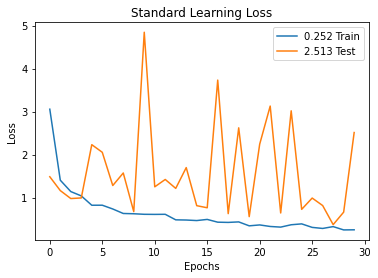

In [416]:
plt.plot(train_losses_com,'-')
plt.plot(eval_losses_com,'-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['0.252 Train','2.513 Test'])
plt.title('Standard Learning Loss')

plt.show()

In [419]:
eval_accu_com[-1]

60.74074074074074

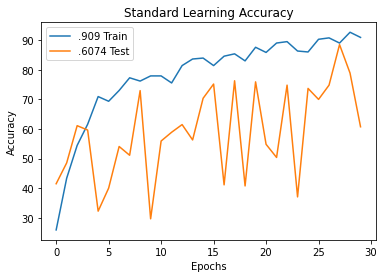

In [420]:
plt.plot(train_accu_com,'-')
plt.plot(eval_accu_com,'-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['.909 Train','.6074 Test'])
plt.title('Standard Learning Accuracy')

plt.show()